In [8]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
import datetime
from IPython.display import HTML
from PIL import Image
from IPython.display import display, clear_output
from functions import SMA, Trend
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
import re

import warnings
warnings.filterwarnings('ignore')

Сущетсвуют спорные мнения о возможности использования метода box count для определния фрактальной размерности временных рядов.
На сегодняшний день для определния фрактальной размерности используют соотношение, обнаруженное Бенуа Мандельбротом

$$ D=2-H $$

где D - фрактальная размерность, а H - коэффициент хёрста, который находится по формуле

$$ H = \frac {\ln(R/S)} {\ln(N/2)} $$

где R — max(n) - min(n),  i = 1..N размах отклонений ряда,  S — среднеквадратичное отклонение значений 

Основная идея показателя Хёрста сводится к тому, что при разбиении временного ряда на участки, будут сохраняться его статистические свойства, который мы оцениваем как отношение размаха к стандартному отклонению.
Существенным минусом данного способа является необходимость в наборе большого количества значений для корректной оценки статистических свойств отдельного участка.

Метод box count определяет фрактальную размреность через "плотонсть" графика. Данные в данном случае представлены в виде матрицы. Однако и тут есть нюанс, в случае если мы имеем малю длину изображения, получаем соответсвующую матрицу меньшего размера а значит и элементы изображения будут находится в непосредственной близости, а значит полученное значение размерности будет завышено.

В данной работе, я попробую найти оптимальные параметры для нахождения фрактальной размрености временного ряда методом box count. Опираясь на тот факт, что значение фрактальной размерности стохастического временного ряда должно стремиться к 1.5, это обусловлено тем, что её сложность должна находится по середине между максимальным и минимальным значениями, стохастиечский ряд не обладает свойствами тренда или закономерности, таким образом не должен обладать свойствами самоподобия.

Смоделируем целочисленный стохастический временной ряд, содержащий 800 значений от 0 до 100

In [9]:
stochastic_df = pd.DataFrame(np.random.randint(0,100,size=(800, 1)), columns=list('R'))
stochastic_df['index'] = [i for i in range(len(stochastic_df))]

In [10]:
stochastic_df['delta'] = stochastic_df['R'] - stochastic_df['R'].shift(1)
start_step = stochastic_df['delta'].abs().min()
end_step = stochastic_df['delta'].max()

Набор значений временного ряда

In [11]:
stochastic_df

,R,index,delta
0,1,0,NaN
1,33,1,32.0
2,7,2,-26.0
3,66,3,59.0
4,89,4,23.0
...,...,...,...
795,30,795,-27.0
796,2,796,-28.0
797,99,797,97.0
798,65,798,-34.0


## Зависимость отношения длины и ширины изображения к фрактальной размрености

In [12]:
optimal_demension_df = pd.read_excel('optimal_demension.xlsx')
optimal_demension_df['Длина/Высота'] = optimal_demension_df['Длина']/optimal_demension_df['Высота']

Мною был сгенерирован набор данных, где меняя длину и ширину изображения рассчитывал фрактальная размерность. Как можно видеть, наболее важным фактором является длина изображения. Отношение сторон матрицы не влияет на результат.

In [13]:
optimal_demension_df.loc[optimal_demension_df['Размерность']==1.5]

,Длина,Высота,dpi,Размерность,std,Длина/Высота
144,180,10,100,1.5,1.29,18.000000
163,190,15,100,1.5,1.29,12.666667
182,200,20,100,1.5,1.29,10.000000
201,210,25,100,1.5,1.29,8.400000
202,210,30,100,1.5,1.30,7.000000
221,220,35,100,1.5,1.29,6.285714
222,220,40,100,1.5,1.29,5.500000
223,220,45,100,1.5,1.30,4.888889
224,220,50,100,1.5,1.30,4.400000
225,220,55,100,1.5,1.30,4.000000


Также это подтверждение мы видим на графике столбчатой диограммы отображающей отношение сторон и полученную размерность.

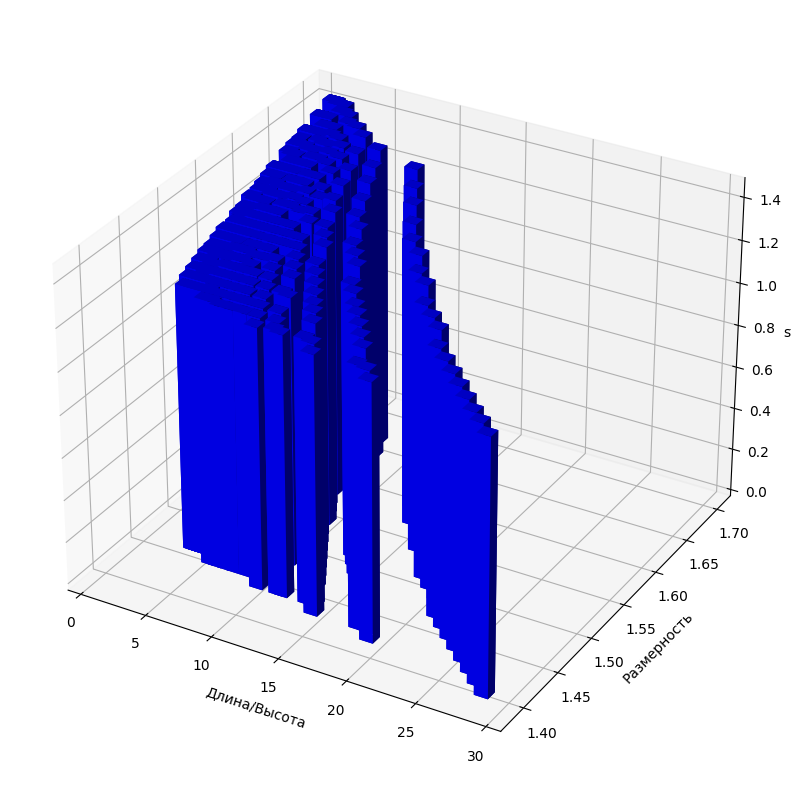

In [14]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Длина/Высота')
ax.set_ylabel('Размерность')
ax.set_zlabel('std')

x_pos = optimal_demension_df['Длина/Высота']
y_pos = optimal_demension_df['Размерность']
z_pos = [0] * len(optimal_demension_df)

x_size = 1
y_size = 0.01
z_size = optimal_demension_df['std']

# ax.scatter(xs, ys, zs, marker=m)
ax.bar3d(x_pos, y_pos, z_pos, x_size, y_size, z_size, color='blue', zsort='average')

## Зависимость фрактальной размерности от длины ряда и изображения

In [23]:
optimal_demension_df = pd.read_excel('optimal_demension_3.xlsx')

In [24]:
optimal_demension_df = optimal_demension_df.loc[(optimal_demension_df['Размерность'] == 1.49) |\
                         (optimal_demension_df['Размерность'] == 1.50) |\
                         (optimal_demension_df['Размерность'] == 1.51)]

In [25]:
optimal_demension_df

,Длина,Ширина,dpi,Размерность,std,Длина_ряда
4,100,50,100,1.50,1.30,400
12,200,50,100,1.49,1.29,800
19,300,50,100,1.50,1.29,1150
20,300,50,100,1.51,1.30,1200
21,300,50,100,1.51,1.31,1250
27,400,50,100,1.49,1.28,1550
28,400,50,100,1.50,1.29,1600
29,400,50,100,1.51,1.30,1650
33,500,50,100,1.49,1.28,1850
34,500,50,100,1.49,1.29,1900


In [29]:
z = np.polyfit(optimal_demension_df['Длина_ряда'], optimal_demension_df['Длина'], 1)
p = np.poly1d(z)

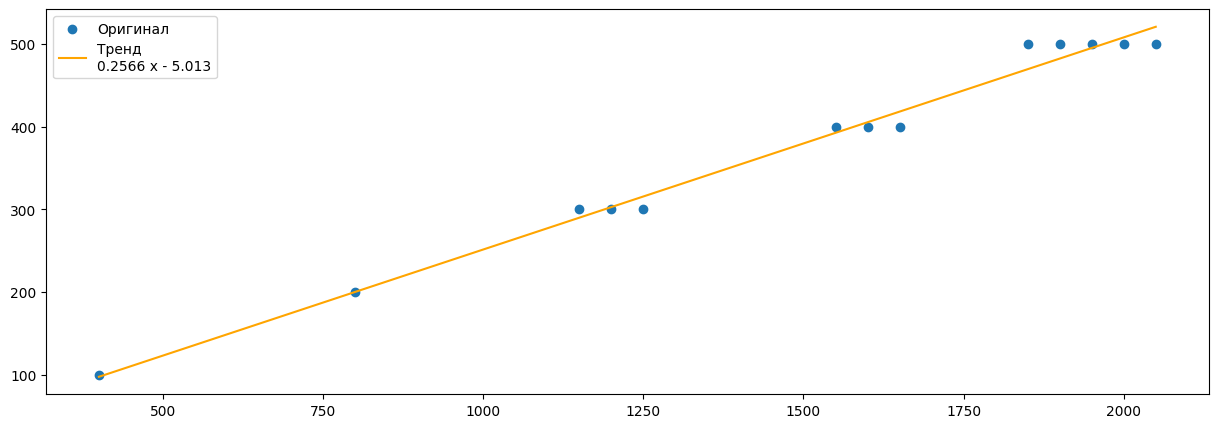

In [32]:
plt.figure(figsize=(15,5))
plt.scatter(optimal_demension_df['Длина_ряда'], optimal_demension_df['Длина'], label=f'Оригинал')
plt.legend()
plt.plot(optimal_demension_df['Длина_ряда'], p(optimal_demension_df['Длина_ряда']), label=f'Тренд {p}', color='orange')
plt.legend()
plt.show()

Как видно из соотношения $ 0.2566 * x - 5 $ длина изображения должна быть в четыре раза меньше длины временного ряда.

## Функции нахождения размерности

In [38]:
def Dimension_Hurst(df, iter=10, show=True, Dimension=False):
    result = pd.DataFrame(columns=['Масштаб', 'Коэффициент'])
    for t in range(iter, 0, -1):
        chunks = np.array_split(df, t)
        R = np.array([(max(chunk) - min(chunk)) for chunk in chunks]).mean()
        S = np.array([np.std(chunk) for chunk in chunks]).mean()
        H = R / S * np.sqrt(len(chunks[0]))
        len_t = len(chunks[0])
        result.loc[len(result)] = [math.log(len_t), math.log(H)]

    z = np.polyfit(result['Масштаб'], result['Коэффициент'], 1)
    p = np.poly1d(z)

    D = round(2 - p[1], 2)
    std = round(np.std(result['Коэффициент']), 2)

    if show:
        plt.figure(figsize=(15, 5))
        plt.scatter(result['Масштаб'], result['Коэффициент'], color='red')
        plt.plot(result['Масштаб'], p(result['Масштаб']))

        plt.ylabel("ln(R/S)")
        plt.xlabel("ln(Длина отрезка)")

        plt.title(f'Размерность = {D}, стандартное отклонение {std}')
        plt.show()
        plt.clf()
        plt.close()
    else:
        plt.clf()
        plt.close()

    if Dimension:
        return D
    return result

In [104]:
def Dimension_BC(df, columns, start_step, end_step, step, show=True, Dimension=False):
    results = []
    steps = [i for i in range(start_step, end_step, step)]

    p1 = columns[0]
    p2 = columns[1]
    
    length = int(len(df)/4)
    width = int(length/4)
    
    plt.figure(figsize=(length, width), dpi=100)
    plt.plot(df[p1], df[p2], color='black')
    plt.axis('off')
    plt.savefig('BC.jpg', bbox_inches='tight', pad_inches=0)
    plt.clf()
    plt.close()

    img = (~np.asarray(Image.open('BC.jpg').convert('1'))).astype(int)
    # Вывод размера изображения
    print(f"Размер изображения в пикселях {img.shape}")

    for step in steps:
        count = 0
        for i in range(1, img.shape[0], step):
            for j in range(1, img.shape[1], step):
                # Получаем срез массива
                window = img[i:i + step, j:j + step]
                # Прибавляем если сумма окна больше нуля
                if window.sum() > 0:
                    count += 1
        results.append(count)

    x = [math.log(step) for step in steps]
    y = [math.log(result) for result in results]

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)

    D = round(p[1] * (-1), 2)
    std = round(np.std(y), 2)

    if show:
        plt.figure(figsize=(15, 5))
        plt.scatter(x, y, color='red')
        plt.plot(x, p(x))

        plt.ylabel("ln(Кол-во занятых квадратов)")
        plt.xlabel("ln(Масштаб)")

        plt.title(f'Размерность = {D}, стандартное отклонение {std}')
        plt.show()
        plt.clf()
        plt.close()
    else:
        plt.clf()
        plt.close()

    if Dimension:
        return D
    return [x, y]

## Распределение частоты изменений

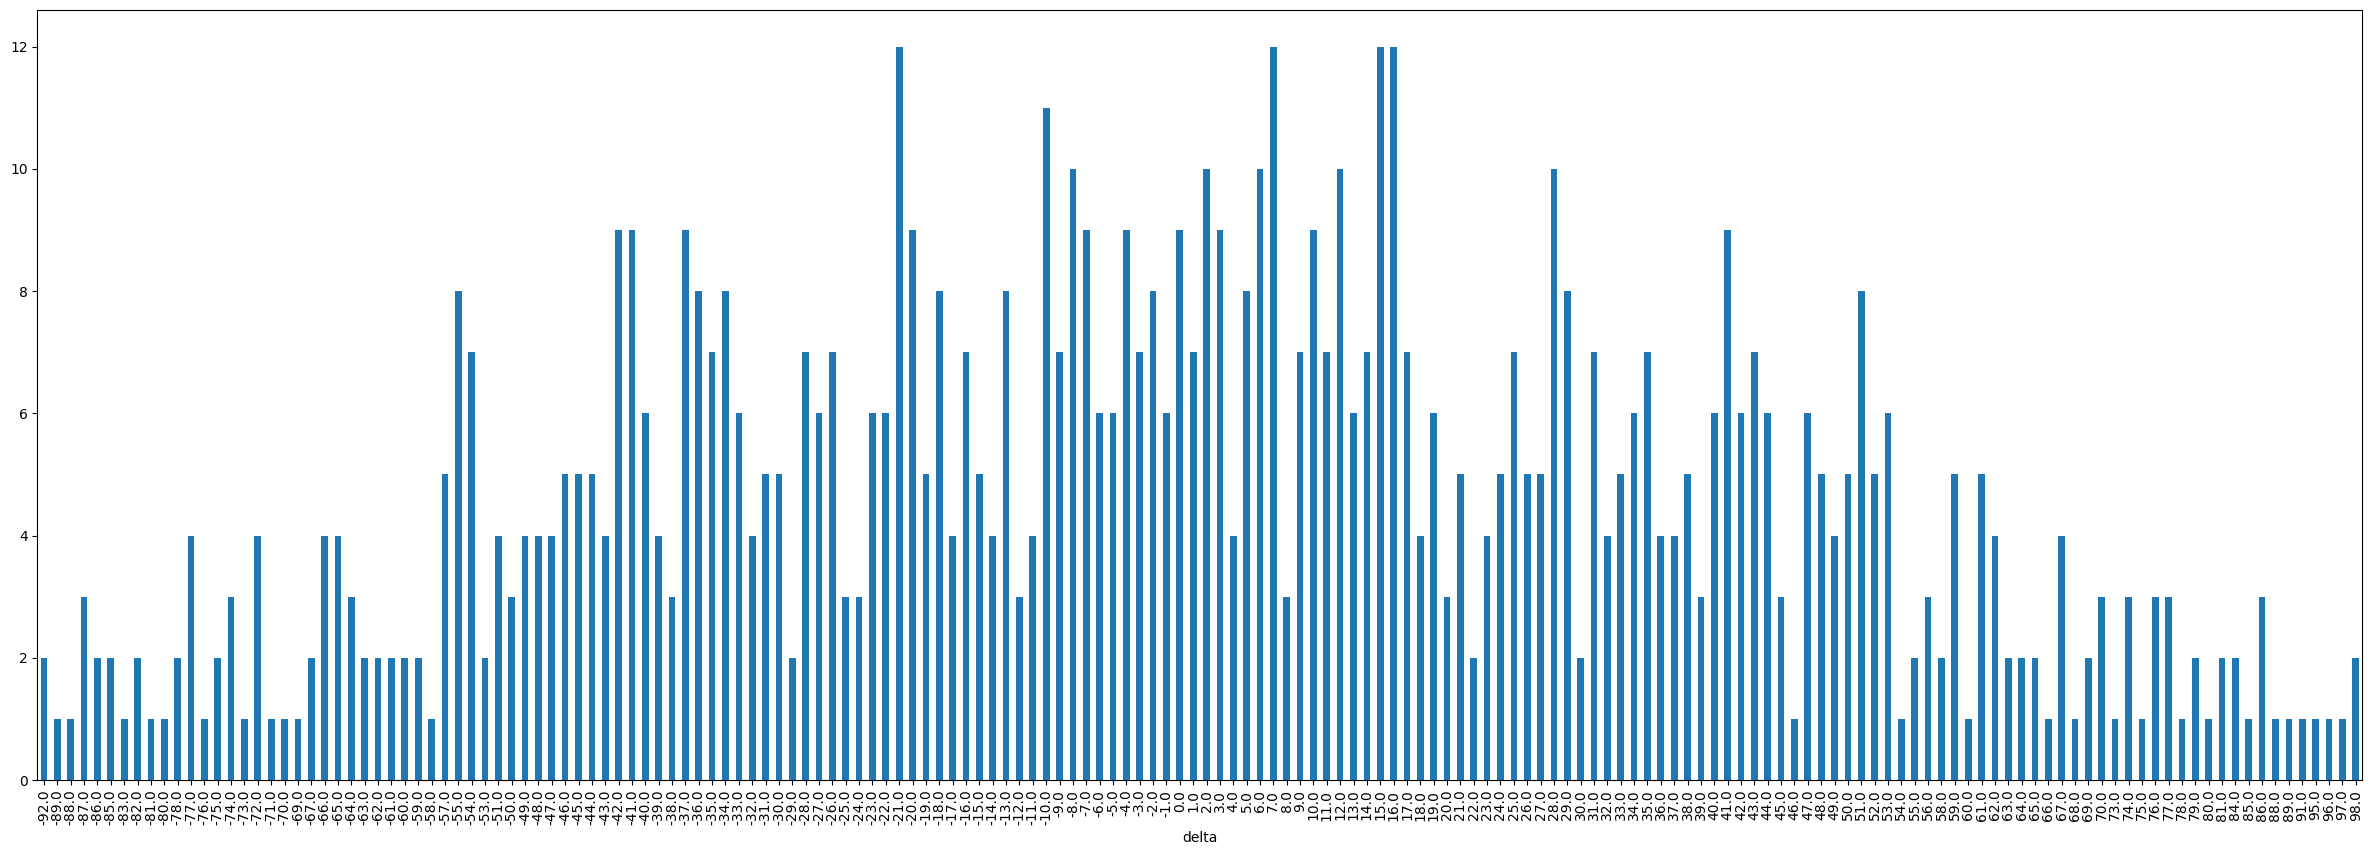

In [105]:
plt.figure(figsize=(30,10))
stochastic_df_bar = stochastic_df.groupby(['delta'])['delta'].count()
ax = stochastic_df_bar.plot.bar(x='delta')
plt.show()

Как можно увидеть из графика частот изменений, небольшое количество значений входит в диапазон [-5;5], значения распределены по законунормального распределения, это означает что основную оценку размерности можно делать по значениям в диапазное от [5;200]

## Зависимость отклонения от количества шагов

Начальный шаг 5
Конечный шаг 200
Шаг 1
Размер изображения в пикселях (3850, 15500)


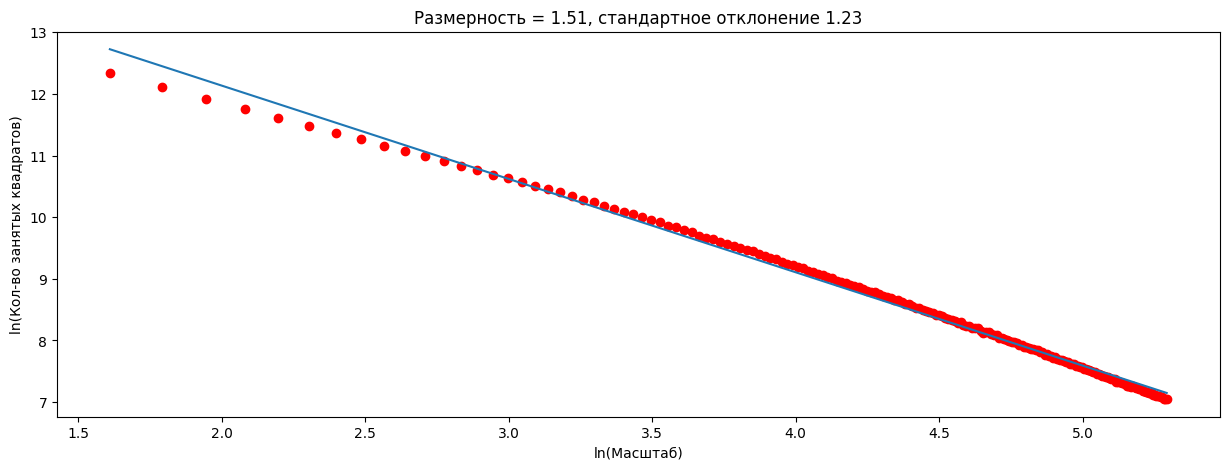

Начальный шаг 5
Конечный шаг 200
Шаг 5
Размер изображения в пикселях (3850, 15500)


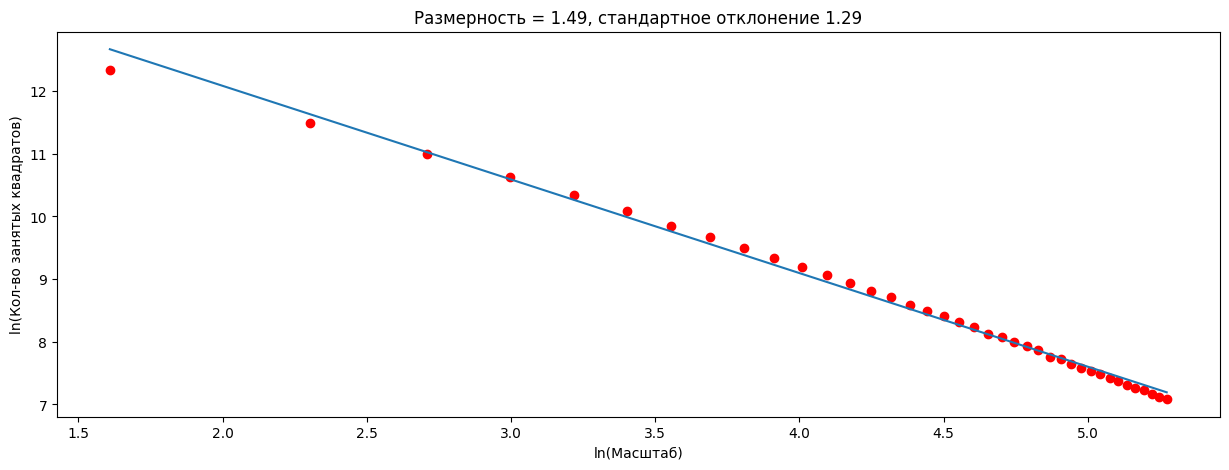

Начальный шаг 5
Конечный шаг 200
Шаг 10
Размер изображения в пикселях (3850, 15500)


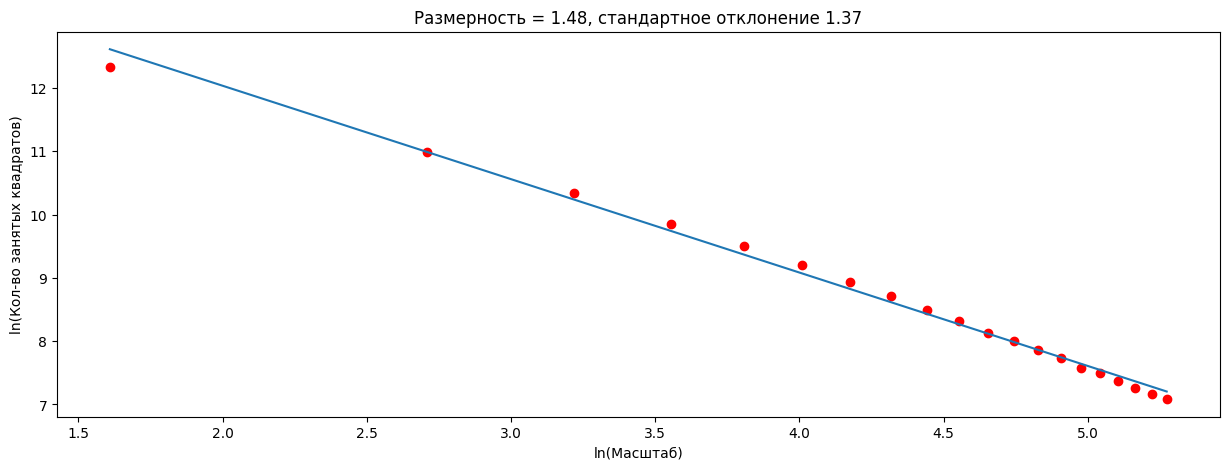

Начальный шаг 5
Конечный шаг 200
Шаг 15
Размер изображения в пикселях (3850, 15500)


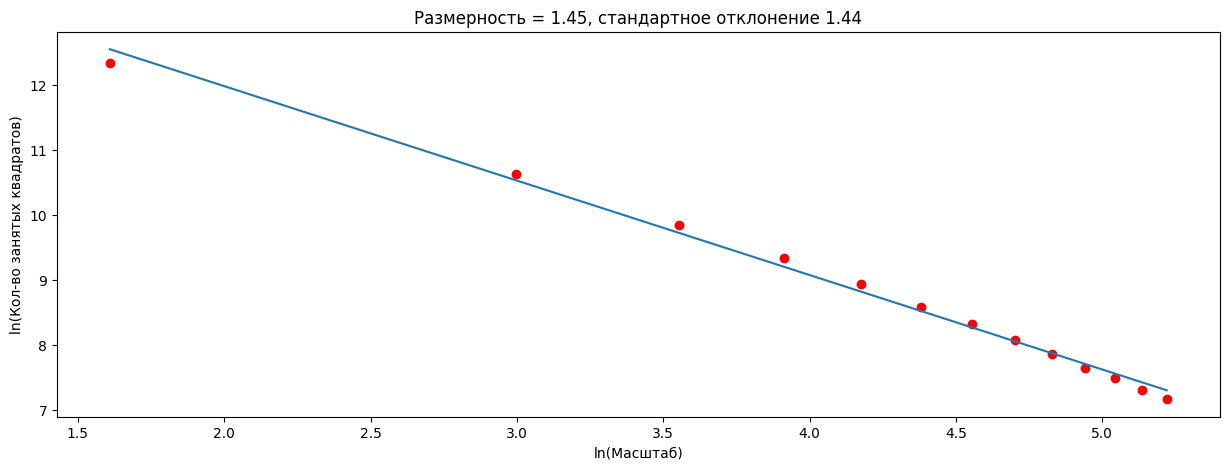

Начальный шаг 5
Конечный шаг 200
Шаг 20
Размер изображения в пикселях (3850, 15500)


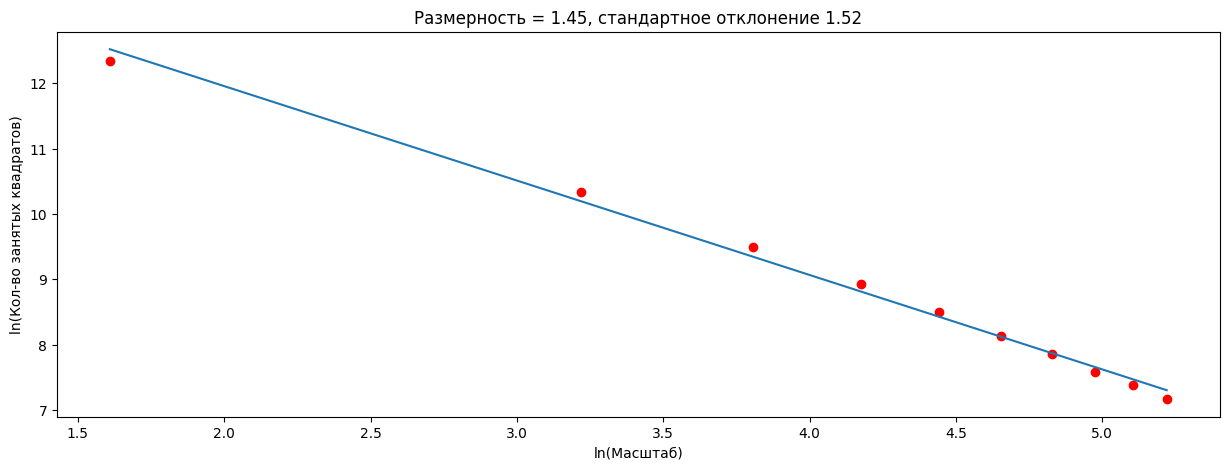

Начальный шаг 5
Конечный шаг 200
Шаг 25
Размер изображения в пикселях (3850, 15500)


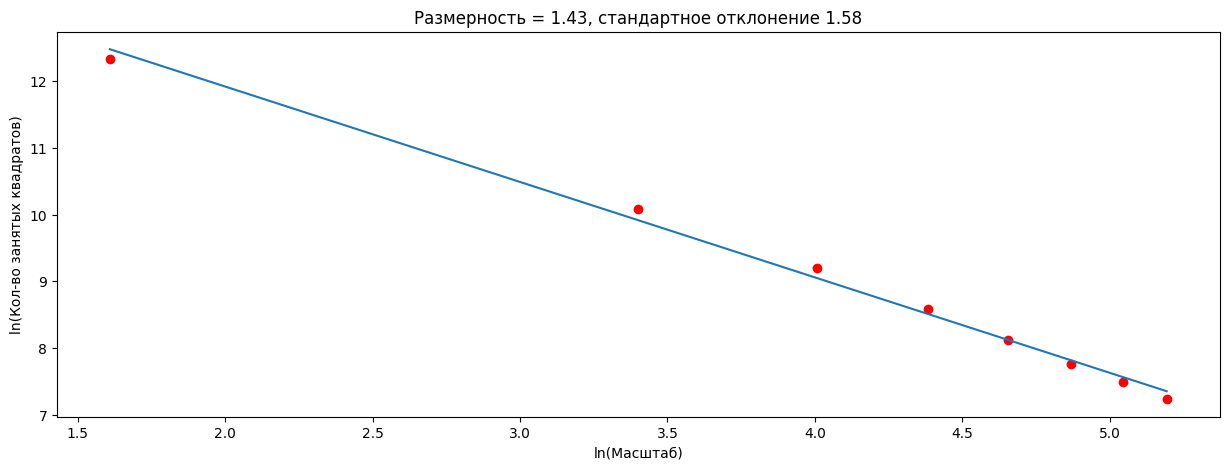

Начальный шаг 5
Конечный шаг 200
Шаг 30
Размер изображения в пикселях (3850, 15500)


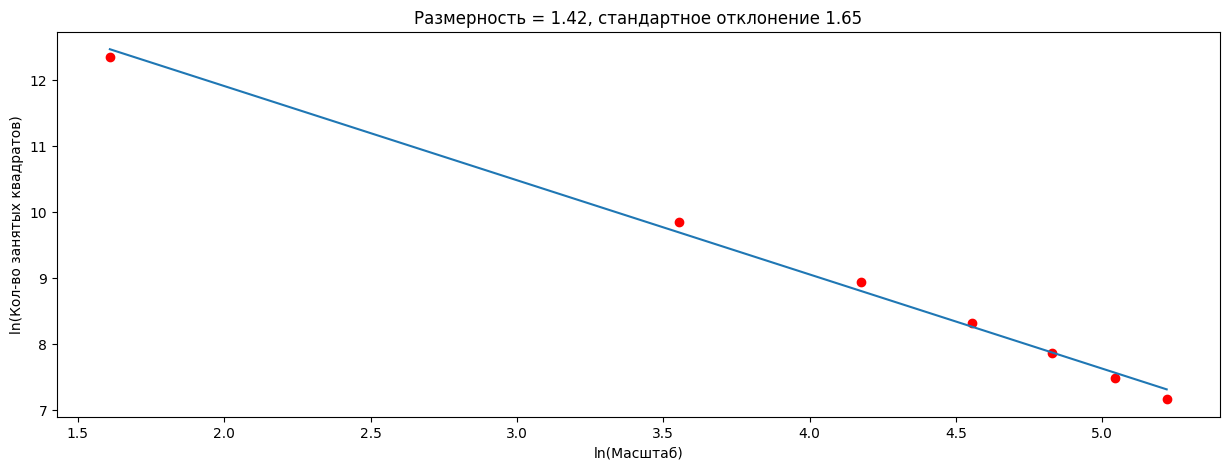

Начальный шаг 5
Конечный шаг 200
Шаг 35
Размер изображения в пикселях (3850, 15500)


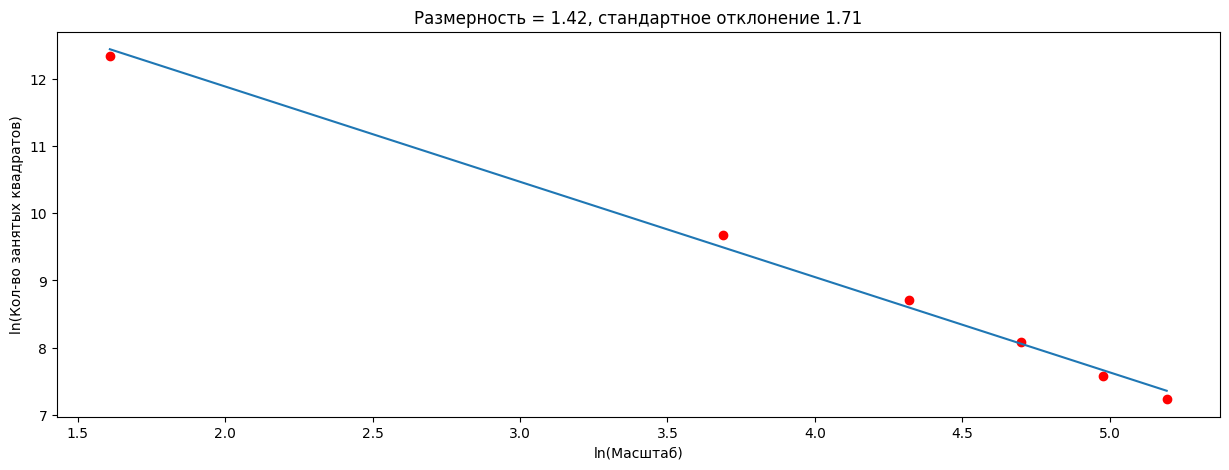

Начальный шаг 5
Конечный шаг 200
Шаг 40
Размер изображения в пикселях (3850, 15500)


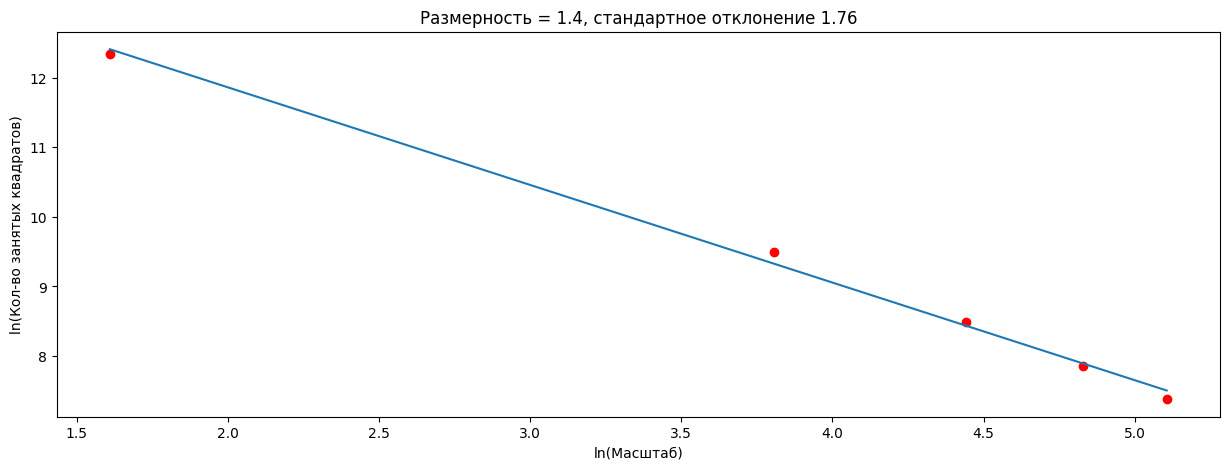

In [106]:
for start_step, end_step, step in zip([5]*9, [200]*9, [1, 5, 10, 15, 20, 25, 30, 35, 40]):
    print(f'Начальный шаг {start_step}')
    print(f'Конечный шаг {end_step}')
    print(f'Шаг {step}')
    D = Dimension_BC(stochastic_df, ['index', 'R'], start_step, end_step, step, show=True, Dimension=False)

Как можем увидеть по полученным результатам, чем меньше шаг тем более подробную информацию мы получаем. В данном случае кажется хорошим решением использовать шаг 1, это минимальный шаг обусловленный размером клетки. Минусом данного шага, являетяется высокая затрата вычислительных ресурсов. 

Хотя на графике мы можем увидеть что временной ряд не является чистым фракталом, но обладает фрактальными свойствами, это видно потому что полученные значения лежат не на прямой, скорее эта линия напомниает синусойду с растощей амплитудой.

В данном случае оптимальным будет шаг в диапазоне от 2 до 5, он позволяет определить размерность, при этом не является менее затратным по вычислению чем шаг 1. Последующее увеличение шага сказывается на резльутатах, приводя к занижению размерности.

## Зависимость отклонения от начального шага

Начальный шаг 5
Конечный шаг 200
Шаг 1
Размер изображения в пикселях (3850, 15500)


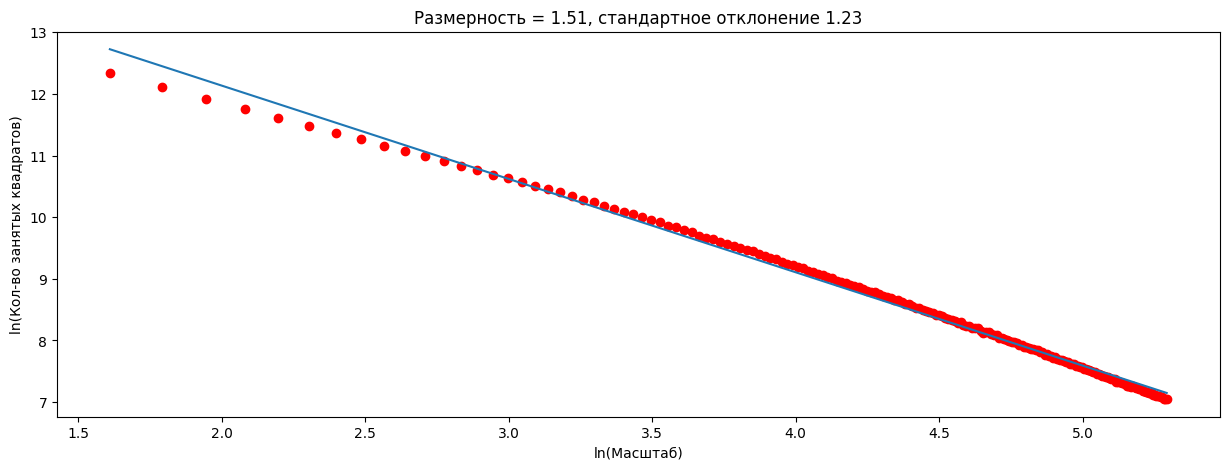

Начальный шаг 10
Конечный шаг 200
Шаг 1
Размер изображения в пикселях (3850, 15500)


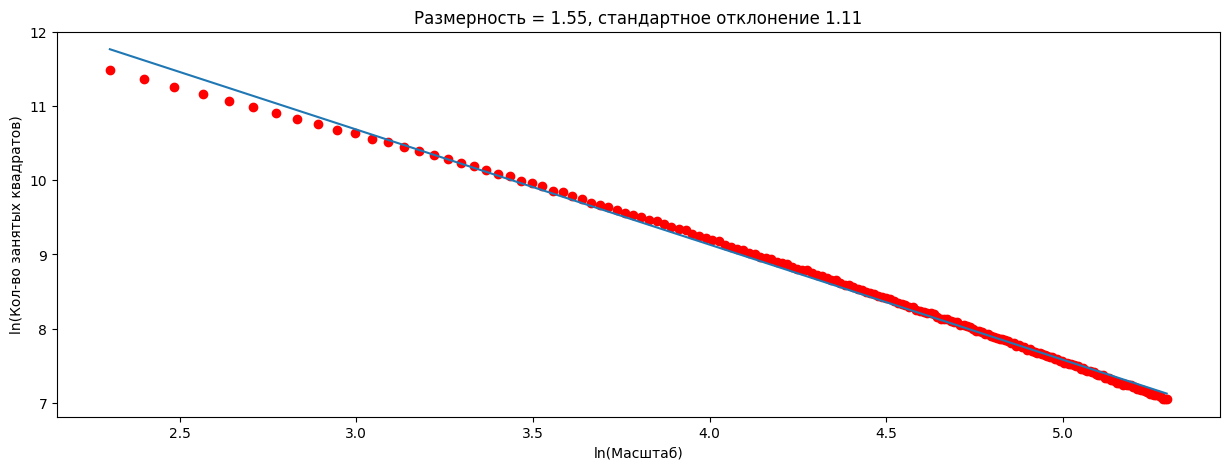

Начальный шаг 20
Конечный шаг 200
Шаг 1
Размер изображения в пикселях (3850, 15500)


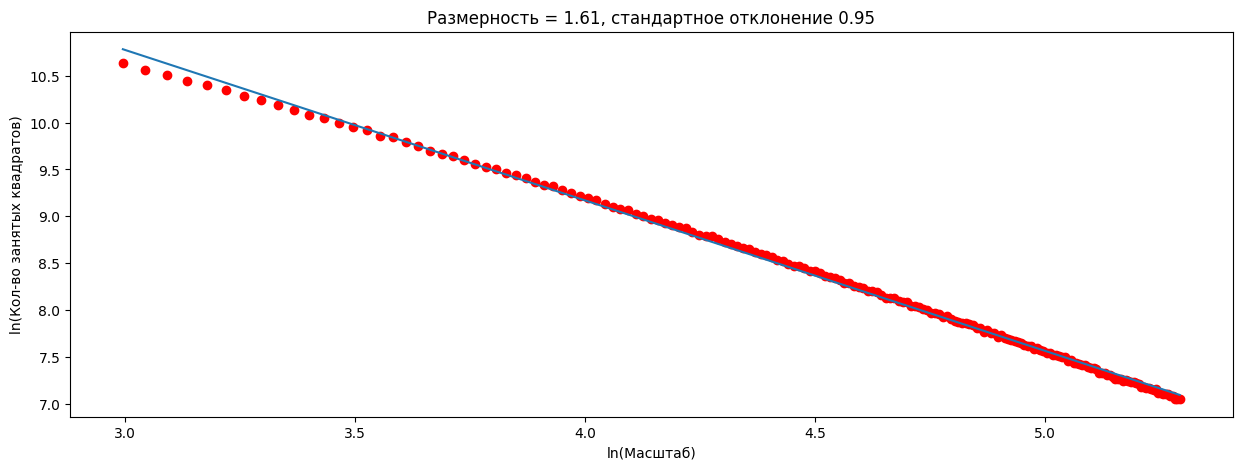

Начальный шаг 30
Конечный шаг 200
Шаг 1
Размер изображения в пикселях (3850, 15500)


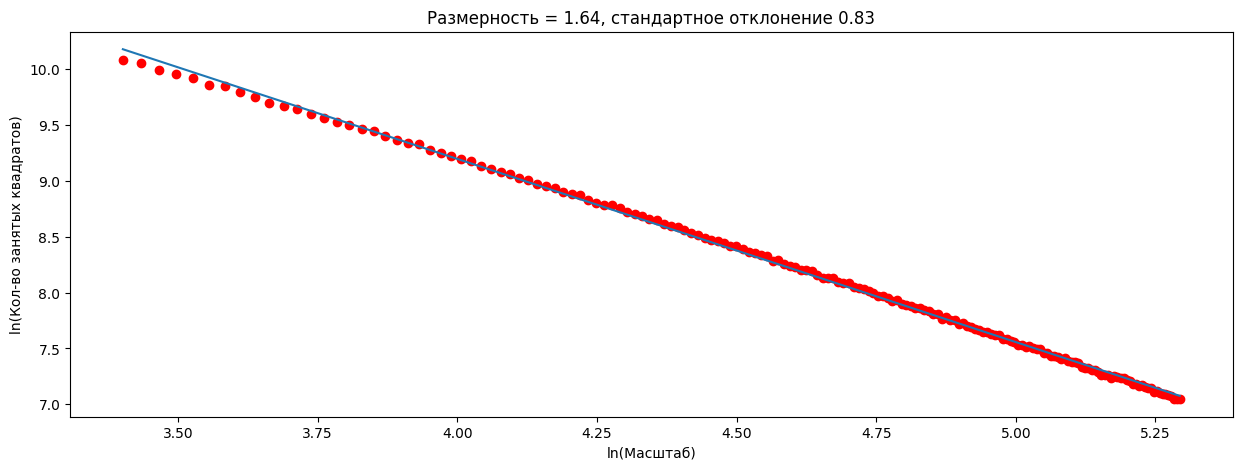

Начальный шаг 40
Конечный шаг 200
Шаг 1
Размер изображения в пикселях (3850, 15500)


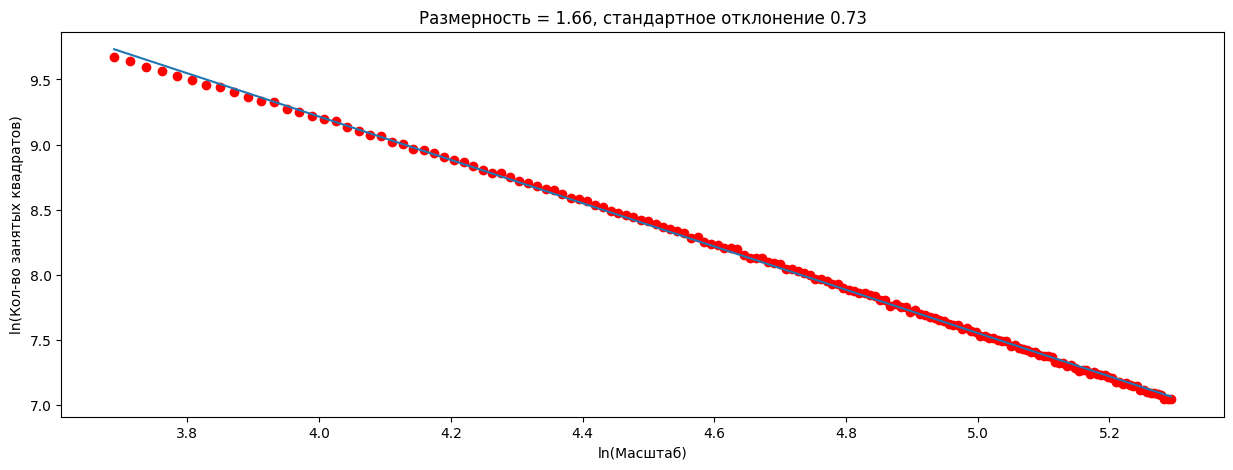

Начальный шаг 50
Конечный шаг 200
Шаг 1
Размер изображения в пикселях (3850, 15500)


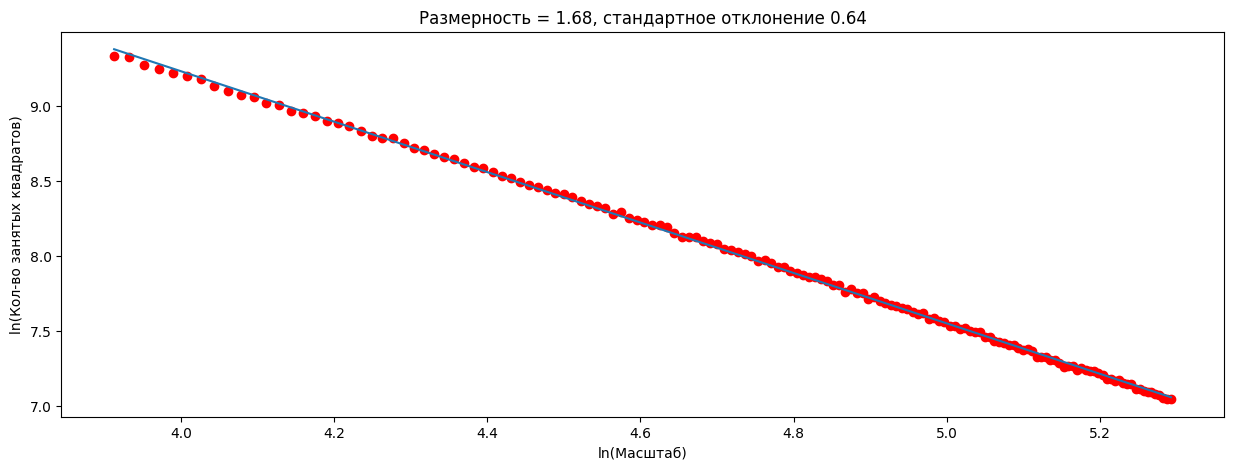

Начальный шаг 60
Конечный шаг 200
Шаг 1
Размер изображения в пикселях (3850, 15500)


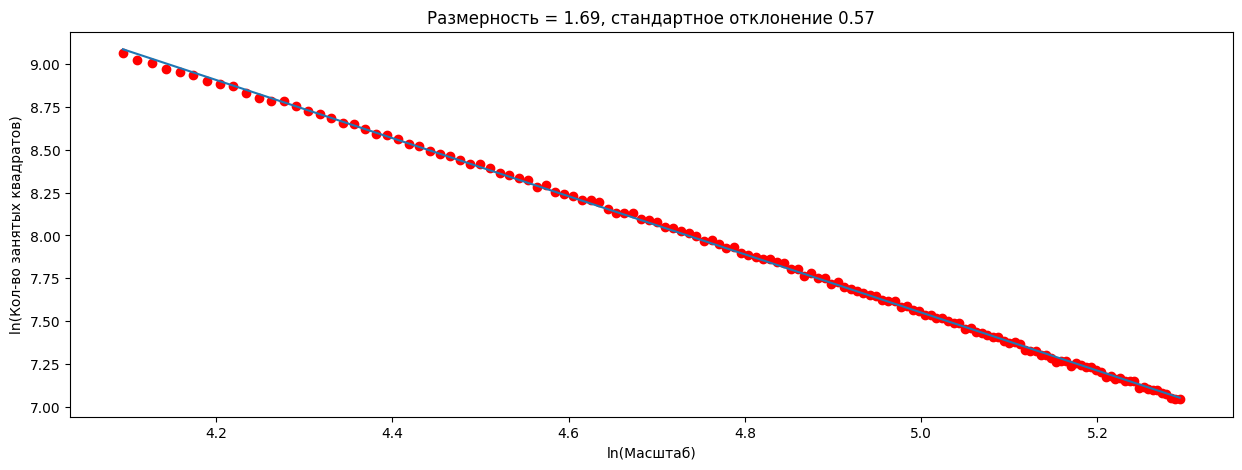

Начальный шаг 70
Конечный шаг 200
Шаг 1
Размер изображения в пикселях (3850, 15500)


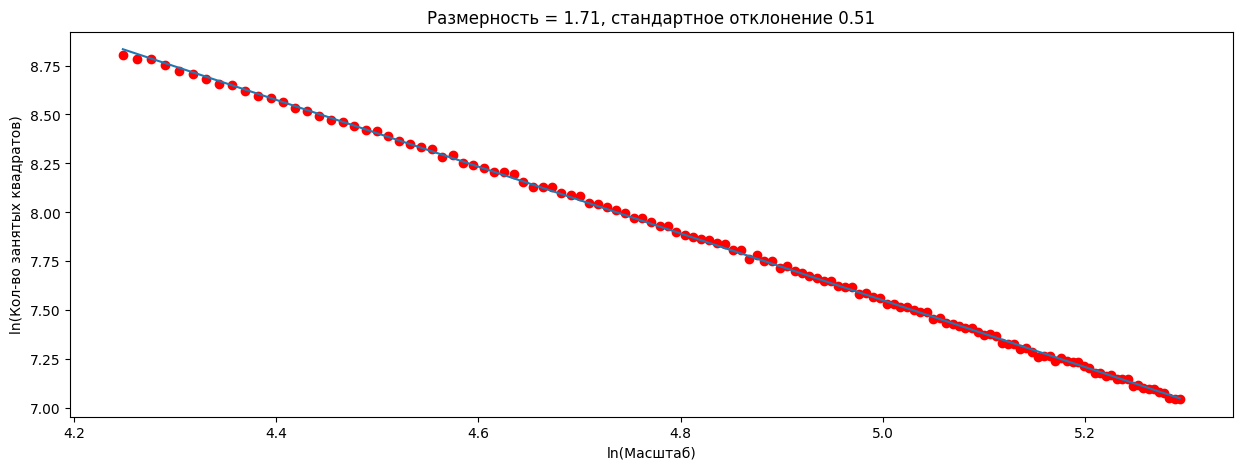

Начальный шаг 80
Конечный шаг 200
Шаг 1
Размер изображения в пикселях (3850, 15500)


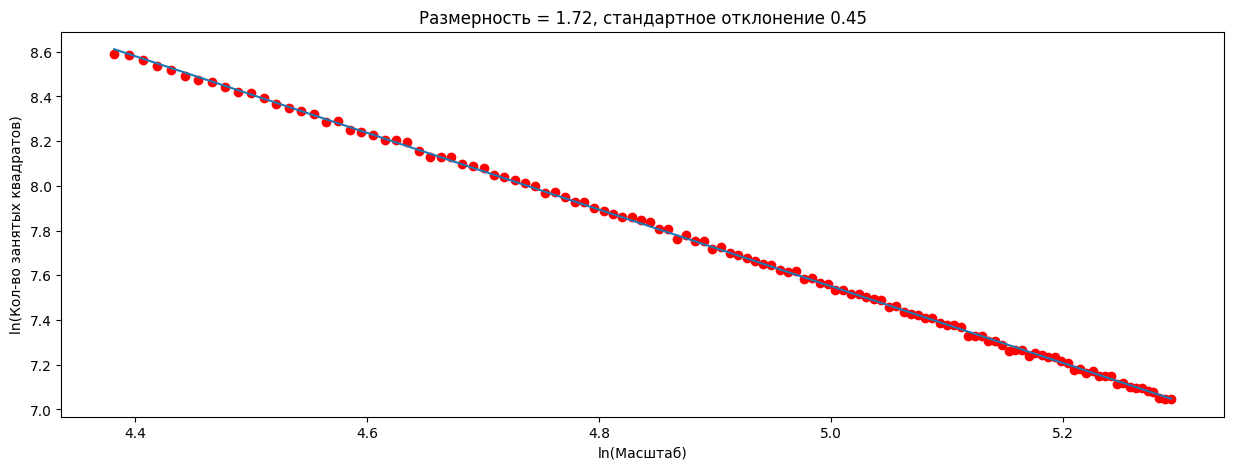

In [107]:
for start_step, end_step, step in zip([5, 10, 20, 30, 40, 50, 60, 70, 80], [200]*9, [1]*9):
    print(f'Начальный шаг {start_step}')
    print(f'Конечный шаг {end_step}')
    print(f'Шаг {step}')
    D = Dimension_BC(stochastic_df, ['index', 'R'], start_step, end_step, step, show=True, Dimension=False)

По полученным результатам можем заметить что увеличение начального шага плохо сказывается на результатах. Объясняется это наличием меньших чем минимальный шаг, структур. При выоборе большого начального окна происходит игнорирование меньших структур, которые также в значительной степени могут влиять на размерность.

## Зависимость отклонения от конечного шага

Начальный шаг 5
Конечный шаг 200
Шаг 1
Размер изображения в пикселях (3850, 15500)


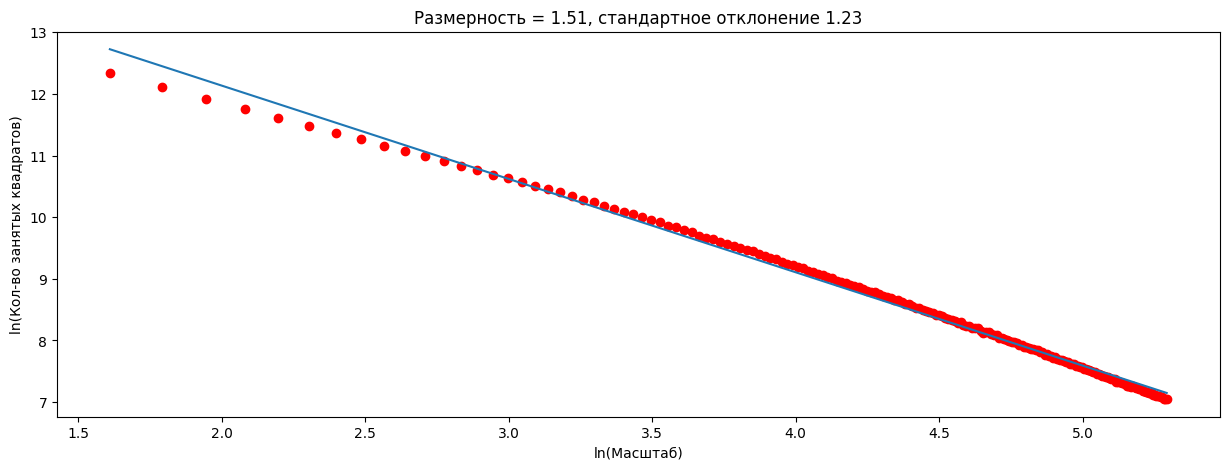

Начальный шаг 5
Конечный шаг 190
Шаг 1
Размер изображения в пикселях (3850, 15500)


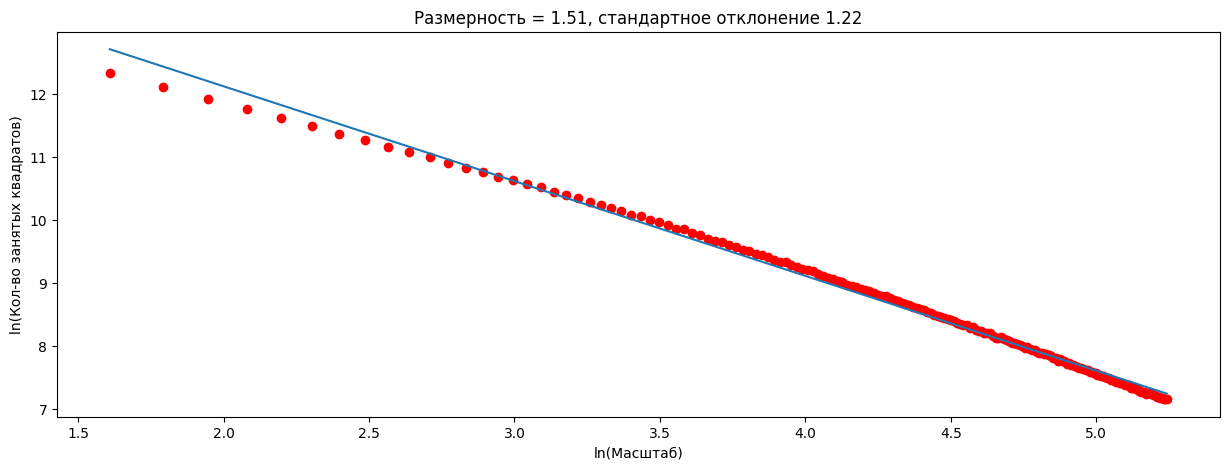

Начальный шаг 5
Конечный шаг 180
Шаг 1
Размер изображения в пикселях (3850, 15500)


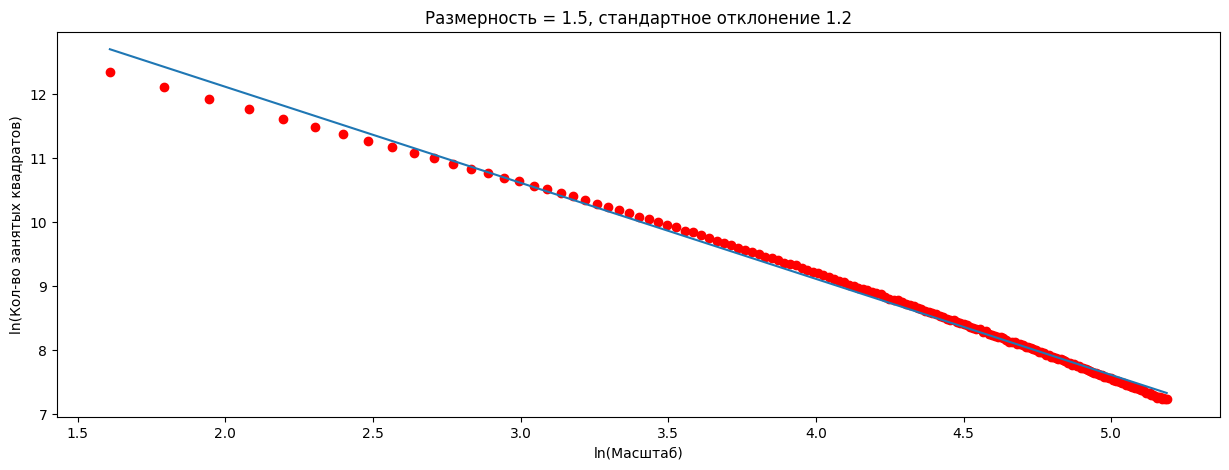

Начальный шаг 5
Конечный шаг 170
Шаг 1
Размер изображения в пикселях (3850, 15500)


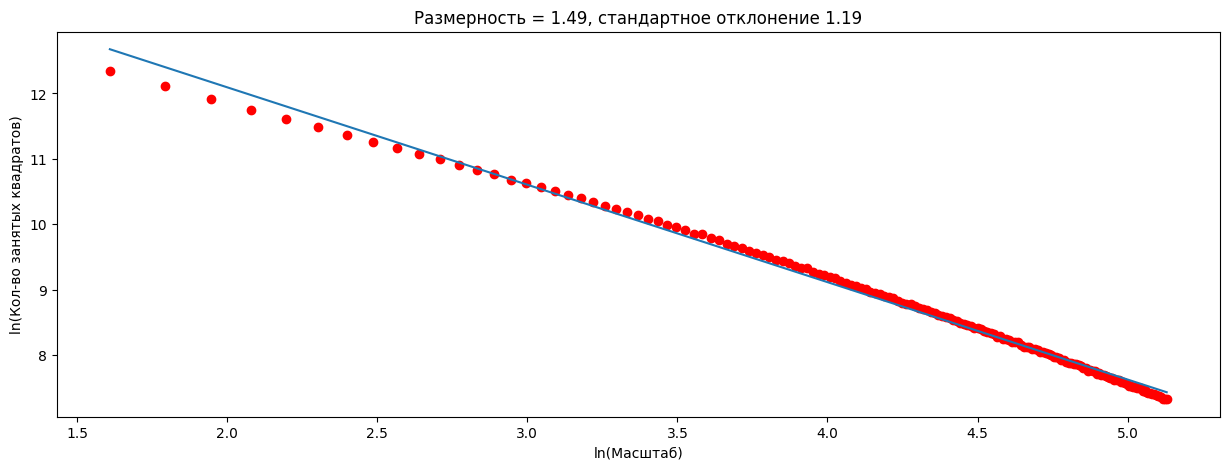

Начальный шаг 5
Конечный шаг 160
Шаг 1
Размер изображения в пикселях (3850, 15500)


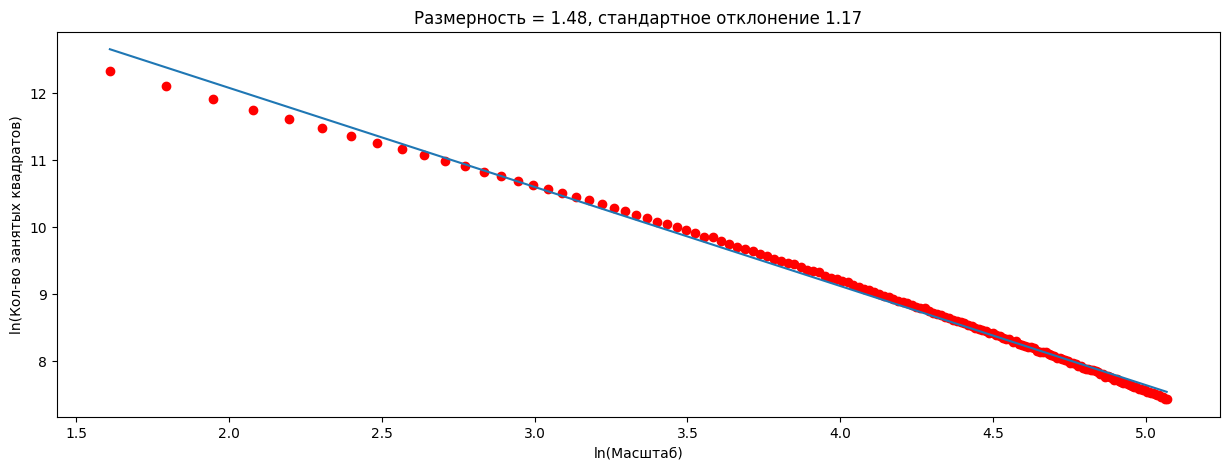

Начальный шаг 5
Конечный шаг 150
Шаг 1
Размер изображения в пикселях (3850, 15500)


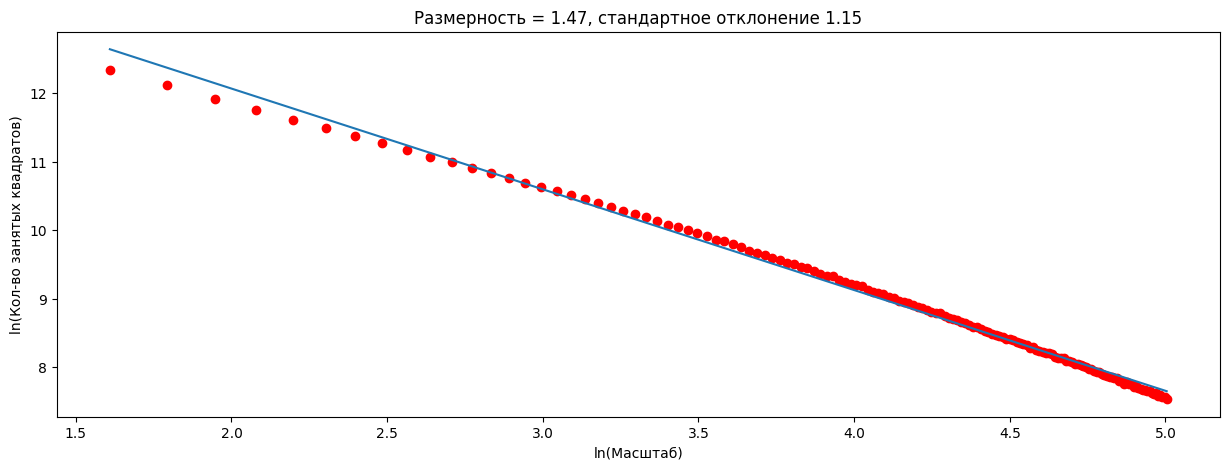

Начальный шаг 5
Конечный шаг 140
Шаг 1
Размер изображения в пикселях (3850, 15500)


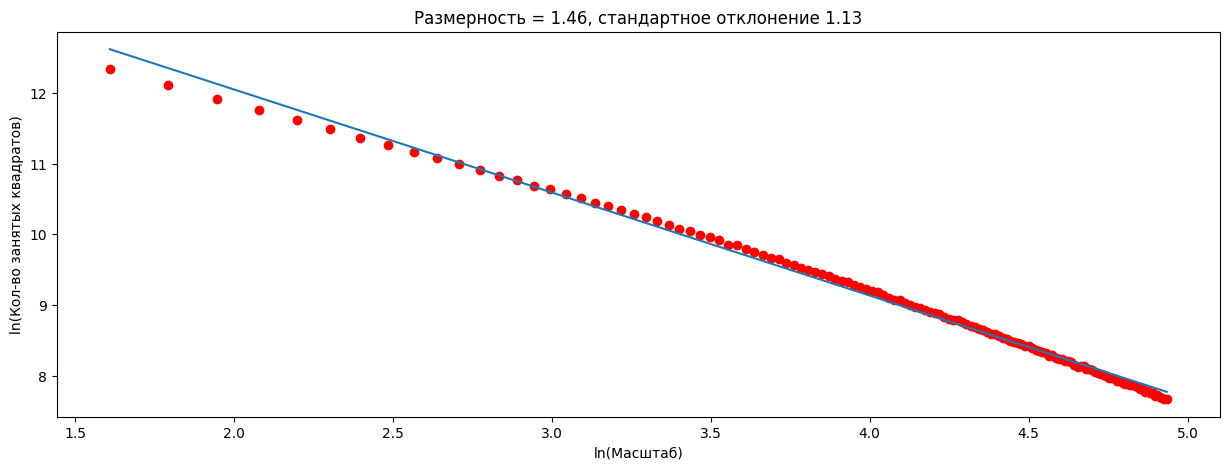

Начальный шаг 5
Конечный шаг 130
Шаг 1
Размер изображения в пикселях (3850, 15500)


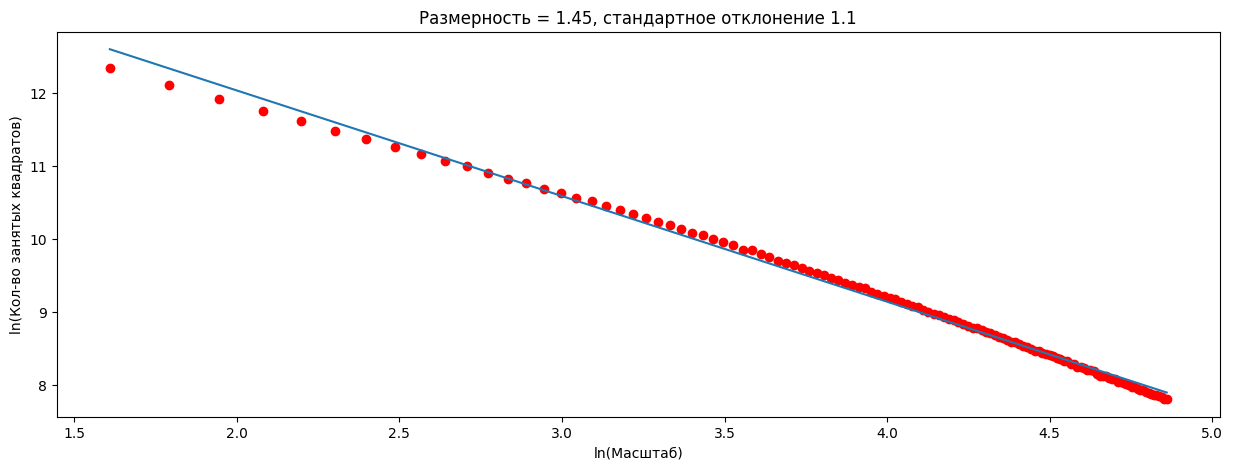

Начальный шаг 5
Конечный шаг 120
Шаг 1
Размер изображения в пикселях (3850, 15500)


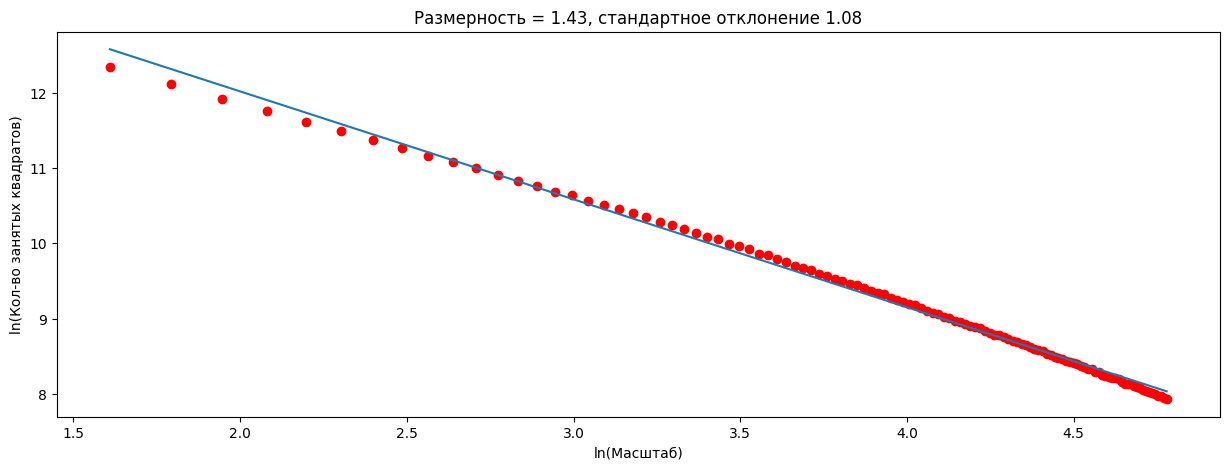

In [108]:
for start_step, end_step, step in zip([5]*9, [200, 190, 180, 170, 160, 150, 140, 130, 120]*9, [1]*9):
    print(f'Начальный шаг {start_step}')
    print(f'Конечный шаг {end_step}')
    print(f'Шаг {step}')
    D = Dimension_BC(stochastic_df, ['index', 'R'], start_step, end_step, step, show=True, Dimension=False)

## Наилучшие параметры

Box count
Размер изображения в пикселях (3850, 15500)


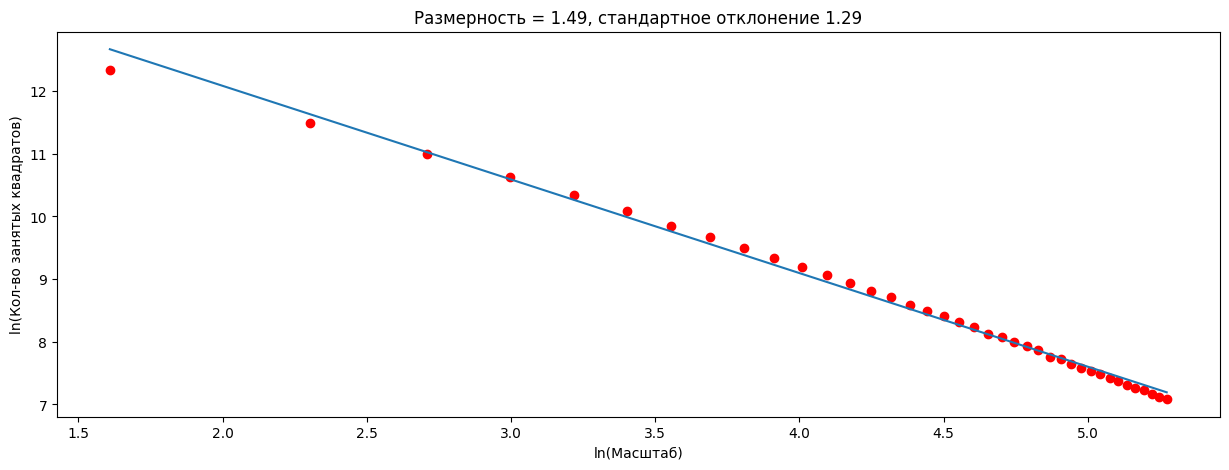

In [109]:
print('Box count')
D = Dimension_BC(stochastic_df, ['index', 'R'], 5, 180, 5, show=True, Dimension=False)

коэф-т Хёрста


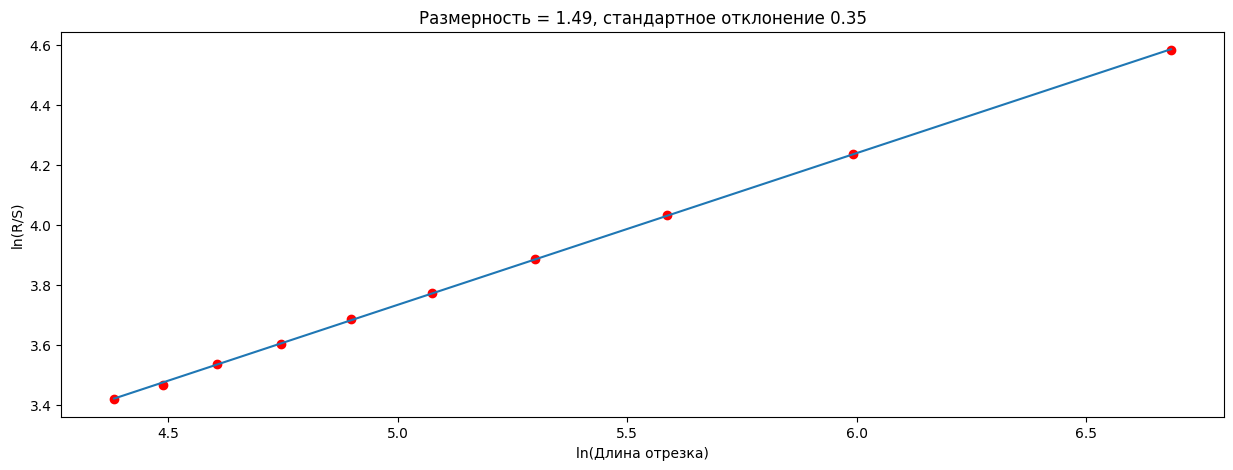

In [110]:
print('коэф-т Хёрста')
D_hurst = Dimension_Hurst(stochastic_df['R'], iter=10, show=True, Dimension=False)

По подобранным параметрам мы можем увидеть корреткно рассчитанную размерность стохастического ряда.

## Преимущества box count метода

Расчитаем фрактальную размерность нашего ряда, однако уменьшим набор значений до 50.

Box count
Размер изображения в пикселях (231, 930)


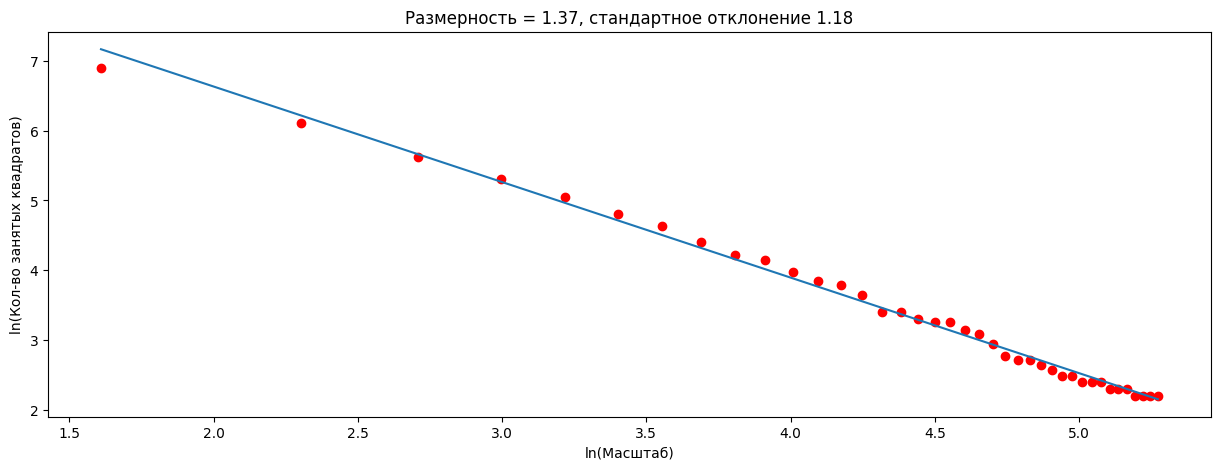

In [111]:
print('Box count')
D = Dimension_BC(stochastic_df[:50], ['index', 'R'], 5, 180, 5, show=True, Dimension=False)

коэф-т Хёрста


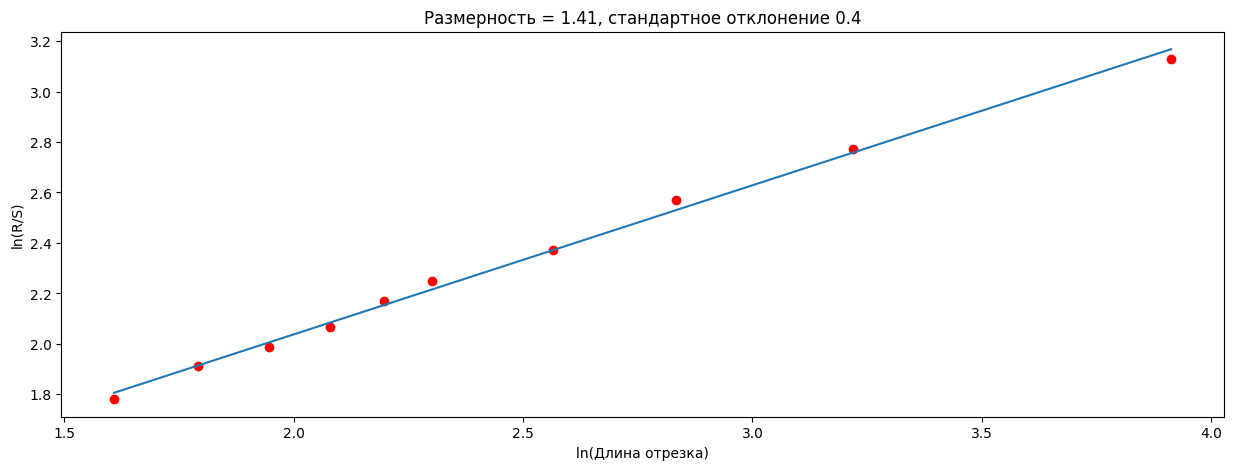

In [112]:
print('коэф-т Хёрста')
D_hurst = Dimension_Hurst(stochastic_df['R'][:50], iter=10, show=True, Dimension=False)

Преимуществом данного метода является возможность оценки фрактальной размерности на небольшом наборе данных

## Сравнение адаптированного box counting и коэф-цт Хёрста

In [113]:
data = pd.read_csv('data/USD_RUB_investing.csv')

In [114]:
data = data.iloc[500:1400]
data['index'] = [i for i in range(len(data))]

In [115]:
data

,Дата,Закрытие,Открытие,Максимум,Минимум,Изм%,index
500,25.11.2021,74.6918,74.9821,74.9904,74.4950,-0.39,0
501,24.11.2021,74.9821,74.2883,75.0379,74.1181,0.93,1
502,23.11.2021,74.2883,74.8046,75.2510,74.1610,-0.69,2
503,22.11.2021,74.8046,73.4834,75.0528,73.2186,1.80,3
504,19.11.2021,73.4834,73.0995,73.6592,72.7025,0.53,4
...,...,...,...,...,...,...,...
1395,15.05.2018,62.3277,61.8468,62.7500,61.7968,0.78,895
1396,14.05.2018,61.8468,61.9193,61.9193,61.5616,-0.12,896
1397,11.05.2018,61.9193,61.7100,62.0341,61.4434,0.34,897
1398,10.05.2018,61.7100,63.2083,63.2250,61.5930,-2.37,898


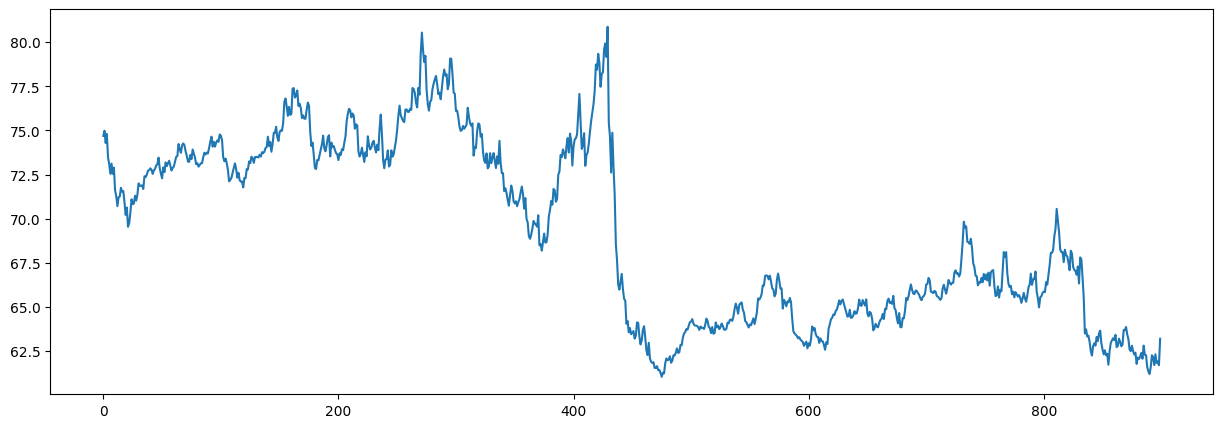

In [116]:
plt.figure(figsize=(15,5))
plt.plot(data['index'], data['Закрытие'])

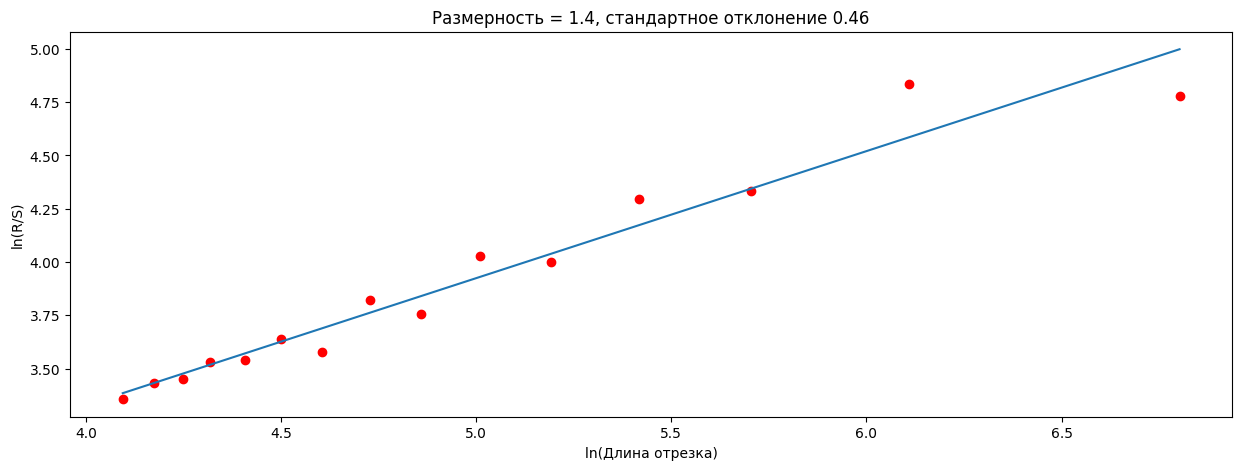

In [117]:
D_hurst = Dimension_Hurst(data['Максимум'], iter=15, show=True, Dimension=False)

Размер изображения в пикселях (4312, 17437)


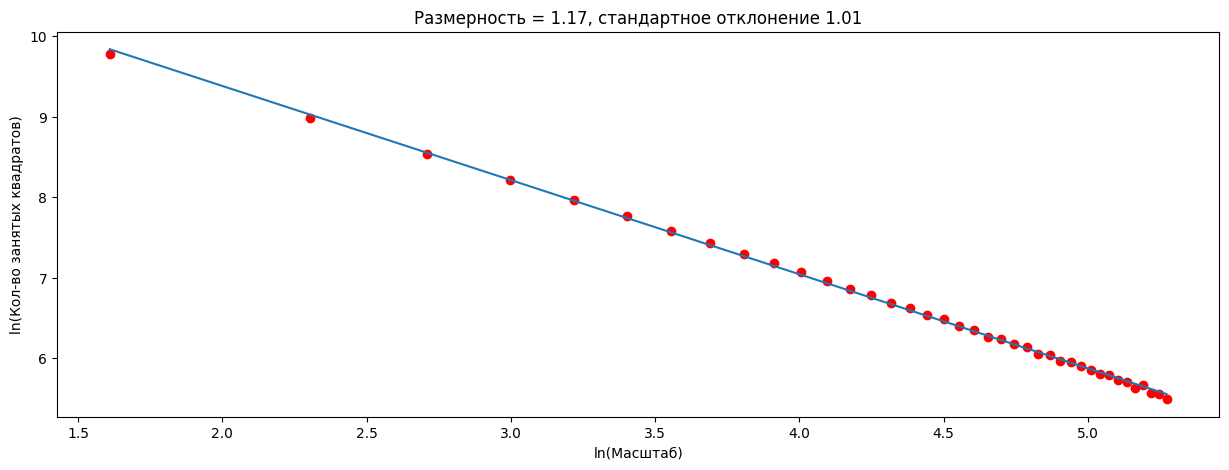

In [118]:
D = Dimension_BC(data, ['index', 'Максимум'], 5, 200, 5, show=True, Dimension=False)

По результатам исследования удалось подобрать оптимальные параметры для применения метода box count, для расчёта фрактальной размерности временных рядов.
Выявлено расхождение значений размерности временного ряда курса валют, обословленное особенностями расчета каждым из методов.
Метод box count позволяет оценить размерность имея небольшой набор данных.